<a href="https://colab.research.google.com/github/ykang917/stock-price-prediction/blob/main/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Prediction RNN 

In this project, I perform a time series prediction using a Recurrent Neural Network regressor. For this example, I will predict Apple's stock price 7 days in advance.

The particular network architecture I will employ for my RNN is a  [Long Short Term Memory (LSTM)](https://en.wikipedia.org/wiki/Long_short-term_memory), which helps significantly avoid technical problems with optimization of RNNs.

# Pytorch LSTM Stock Predictor

This is a Pytorch version of the original Keras LSTM Stock Predictor provided by [Super DataScience](https://www.superdatascience.com/deep-learning/), and also available elsewhere in this repo as a notebook.

## Step 1: Loading the data

First let's load in our time series - a history of around 140 days of Apple's stock price. Then we need to perform a number of pre-processing steps to prepare it for use with an RNN model.  First off, it is good practice to normalize time series - by normalizing its range.  This helps us avoid serious numerical issues associated with how common activation functions (like tanh) transform very large (positive or negative) numbers, as well as helping us to avoid related issues when computing derivatives.

Here we normalize the series to lie in the range [0,1] [using this scikit function](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html).

In [ ]:
# download the data
!wget https://raw.githubusercontent.com/tonylaioffer/stock-prediction-lstm-using-keras/master/data/sandp500/all_stocks_5yr.csv

--2021-10-15 14:14:16--  https://raw.githubusercontent.com/tonylaioffer/stock-prediction-lstm-using-keras/master/data/sandp500/all_stocks_5yr.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29580549 (28M) [text/plain]
Saving to: ‘all_stocks_5yr.csv’

all_stocks_5yr.csv  100%[===================>]  28.21M   159MB/s    in 0.2s    

2021-10-15 14:14:18 (159 MB/s) - ‘all_stocks_5yr.csv’ saved [29580549/29580549]



In [ ]:
!ls .

all_stocks_5yr.csv  sample_data


In [ ]:
 !pip install ray -U

     |████████████████████████████████| 54.0 MB 38 kB/s 
     |████████████████████████████████| 72 kB 561 kB/s 


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch.nn as nn
import torch
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

In [ ]:
# Importing the training set
dataset = pd.read_csv('./all_stocks_5yr.csv')
# dataset_cl = dataset[dataset['Name']=='AMZN'].close.values

# dataset_train = pd.read_csv('Google_Stock_Price_Train.csv')
# training_set = dataset_train.iloc[:, 1:2].values

In [ ]:
dataset_amzn = dataset[dataset['Name'] == 'AMZN']
price = dataset_amzn[['close']]
price

,close
46387,261.95
46388,257.21
46389,258.70
46390,269.47
46391,269.24
...,...
47641,1390.00
47642,1429.95
47643,1390.00
47644,1442.84


## Step 2:  Cutting our time series into sequences

Remember, our time series is a sequence of numbers that we can represent in general mathematically as 

$$s_{0},s_{1},s_{2},...,s_{P}$$

where $s_{p}$ is the numerical value of the time series at time period $p$ and where $P$ is the total length of the series.  In order to apply our RNN we treat the time series prediction problem as a regression problem, and so need to use a sliding window to construct a set of associated input/output pairs to regress on.  This process is animated in the gif below.

<img src="https://github.com/tonylaioffer/stock-prediction-lstm-using-keras/raw/master/images/timeseries_windowing_training.gif" width=600 height=288/>

For example - using a window of size T = 5 (as illustrated in the gif above) we produce a set of input/output pairs like the one shown in the table below

$$\begin{array}{c|c}
\text{Input} & \text{Output}\\
\hline \color{CornflowerBlue} {\langle s_{1},s_{2},s_{3},s_{4},s_{5}\rangle} & \color{Goldenrod}{ s_{6}} \\
\ \color{CornflowerBlue} {\langle s_{2},s_{3},s_{4},s_{5},s_{6} \rangle } & \color{Goldenrod} {s_{7} } \\
\color{CornflowerBlue}  {\vdots} & \color{Goldenrod} {\vdots}\\
\color{CornflowerBlue} { \langle s_{P-5},s_{P-4},s_{P-3},s_{P-2},s_{P-1} \rangle } & \color{Goldenrod} {s_{P}}
\end{array}$$

Notice here that each input is a sequence (or vector) of length 4 (and in general has length equal to the window size T) while each corresponding output is a scalar value.  Notice also how given a time series of length P and window size T = 5 as shown above, we created P - 5  input/output pairs.  More generally, for a window size T we create P - T such pairs.

Now let's window the input time series as described above!  

## Step 3: Split training and testing sets

In order to perform proper testing on our dataset we will lop off the last 1/3 of it for validation (or testing).  

Note how here we are **not** splitting the dataset *randomly* as one typically would do when validating a regression model.  This is because our input/output pairs *are related temporally*.   We don't want to validate our model by training on a random subset of the series and then testing on another random subset, as this simulates the scenario that we receive new points *within the timeframe of our training set*.  

We want to train on one solid chunk of the series (in our case, the first full 2/3 of it), and validate on a later chunk (the last 1/3) as this simulates how we would predict *future* values of a time series.

In [ ]:
# split the data into training data and testing data
price_train = price[:int(len(price)*.8)]
price_test = price[int(len(price)*.8):]

In [ ]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler().fit(price_train)

# scale the data
train_dataset = sc.transform(price_train)
test_dataset = sc.transform(price_test)

In [ ]:
train_dataset

array([[0.02301511],
       [0.01506383],
       [0.01756328],
       ...,
       [0.94269706],
       [0.9384027 ],
       [0.94655528]])

In [ ]:
def split_data(dataset, lookback):
    # data_raw = dataset.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(dataset) - lookback): 
        data.append(dataset[index: index + lookback])
    
    data = np.array(data);  
    X = data[:,:-1,:]
    y = data[:,-1,:]
    
    return [X, y]
lookback = 20 # choose sequence length
x_train, y_train = split_data(train_dataset, lookback)
x_test, y_test = split_data(test_dataset, lookback)

In [ ]:
x_train.shape

(987, 19, 1)

## Transform them into tensors.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
x_train_tensor = torch.from_numpy(x_train).float().to(device)
x_test_tensor = torch.from_numpy(x_test).float().to(device)
y_train_tensor = torch.from_numpy(y_train).float().to(device)
y_test_tensor = torch.from_numpy(y_test).float().to(device)

In [ ]:
x_train_tensor.size()

torch.Size([987, 19, 1])

In [ ]:
# # reshaping
# X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
# X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

## Step 4:  Build and run an RNN regression model

Having created input/output pairs out of our time series and cut this into training/testing sets, we can now begin setting up our RNN.  We use Keras to quickly build a two hidden layer RNN of the following specifications

- layer 1 uses an LSTM module with 5 hidden units (note here the input_shape = (window_size,1))
- layer 2 uses a fully connected module with one unit
- the 'mean_squared_error' loss should be used

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout=1):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_dim, 
            hidden_dim, 
            num_layers, 
            batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.to(device), c0.to(device)))
        out = self.fc(out[:, -1, :]) 
        return out

In [ ]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.to(device)))
        out = self.fc(out[:, -1, :]) 
        return out

In [ ]:
input_dim = 1
hidden_dim = 64
num_layers = 3
output_dim = 1
num_epochs = 500

In [ ]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
model.to(device)

optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss(reduction='mean')

In [ ]:
# model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
# model.to(device)

# loss_fn = torch.nn.MSELoss(reduction='mean')
# optimiser = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
"""
class StockDataset(Dataset):
    
    def __init__(self, X_dataset, Y_dataset):
        
        self.X_dataset = torch.from_numpy(X_dataset)
        self.Y_dataset = torch.from_numpy(Y_dataset)
        
    def __len__(self):
        return np.shape(self.Y_dataset)[0]

    def __getitem__(self, idx):
        sample = {'Sequence': self.X_dataset[:,idx,:], "Target": self.Y_dataset[idx]}

        return sample
"""

'\nclass StockDataset(Dataset):\n    \n    def __init__(self, X_dataset, Y_dataset):\n        \n        self.X_dataset = torch.from_numpy(X_dataset)\n        self.Y_dataset = torch.from_numpy(Y_dataset)\n        \n    def __len__(self):\n        return np.shape(self.Y_dataset)[0]\n\n    def __getitem__(self, idx):\n        sample = {\'Sequence\': self.X_dataset[:,idx,:], "Target": self.Y_dataset[idx]}\n\n        return sample\n'

In [ ]:
# Train_ds=StockDataset(X_train, y_train)

In [ ]:
import time
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []
for t in range(num_epochs):
    model.train()
    y_train_pred = model(x_train_tensor)
    loss = loss_fn(y_train_pred, y_train_tensor)
    print(f'Epoch {t}, MSE: {loss.item()}')
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

    if t % 20 == 0:
      model.eval()
      y_test_pred = model(x_test_tensor)
      test_loss = loss_fn(y_test_pred, y_test_tensor)
      print(f'Epoch {t}, evaluation loss: {test_loss.item()}\n')
    
training_time = time.time() - start_time
print(f"Training time: {training_time}")

Epoch 0, MSE: 0.27434900403022766
Epoch 0, evaluation loss: 1.8585189580917358

Epoch 1, MSE: 0.25118085741996765
Epoch 2, MSE: 0.22936709225177765
Epoch 3, MSE: 0.20838934183120728
Epoch 4, MSE: 0.1878884881734848
Epoch 5, MSE: 0.16765138506889343
Epoch 6, MSE: 0.1476195901632309
Epoch 7, MSE: 0.1279844492673874
Epoch 8, MSE: 0.10938854515552521
Epoch 9, MSE: 0.09336446225643158
Epoch 10, MSE: 0.0831856057047844
Epoch 11, MSE: 0.0844416692852974
Epoch 12, MSE: 0.09674324840307236
Epoch 13, MSE: 0.10196903347969055
Epoch 14, MSE: 0.09633651375770569
Epoch 15, MSE: 0.08714950829744339
Epoch 16, MSE: 0.07983547449111938
Epoch 17, MSE: 0.07588384300470352
Epoch 18, MSE: 0.0745512992143631
Epoch 19, MSE: 0.0745464563369751
Epoch 20, MSE: 0.07479008287191391
Epoch 20, evaluation loss: 0.8129554390907288

Epoch 21, MSE: 0.07456395030021667
Epoch 22, MSE: 0.07344236224889755
Epoch 23, MSE: 0.0711967796087265
Epoch 24, MSE: 0.06773296743631363
Epoch 25, MSE: 0.06307648867368698
Epoch 26, MSE: 

In [ ]:
model.fc.bias

Parameter containing:
tensor([0.0473], device='cuda:0', requires_grad=True)

## Step 5: Checking model performance

With our model fit we can now make predictions on both our training and testing sets.

history

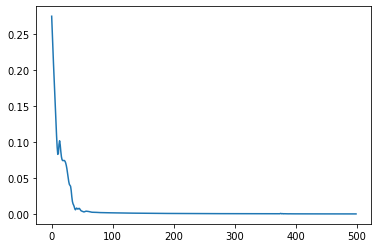

In [ ]:
plt.plot(hist)
# dplt.plot(history.history['val_loss'])

In [ ]:
# X_train_X_test = np.concatenate((X_train, X_test),axis=0)
# hidden_state = None
model.eval()
# test_inputs = torch.tensor(X_test).float().cuda()
test_predict = model(x_test_tensor)
test_predict_cpu = test_predict.cpu().detach().numpy()

In [ ]:
test_predict_cpu.shape

(232, 1)

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(sc.inverse_transform(y_test), sc.inverse_transform(test_predict_cpu))
r2 = r2_score(sc.inverse_transform(y_test), sc.inverse_transform(test_predict_cpu))

r2

0.8992569792677093

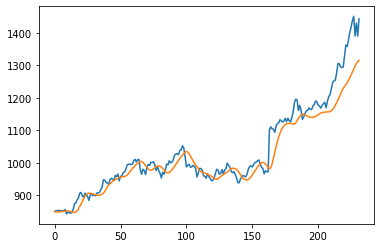

In [ ]:
plt.plot(sc.inverse_transform(y_test.reshape(-1,1)))
plt.plot(sc.inverse_transform(test_predict_cpu.reshape(-1,1)))

In [ ]:
train_pred.shape

torch.Size([987, 1])

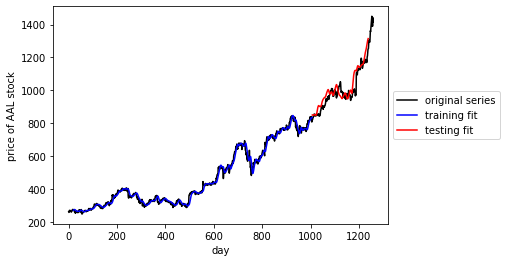

In [ ]:
# plot original data
plt.plot(price['close'].values.reshape(-1,1), color='k')

# train_inputs = torch.tensor(X_train).float().cuda()
train_pred = model(x_train_tensor)
train_pred_cpu = train_pred.cpu().detach().numpy()

# use hidden state from previous training data
test_predict = model(x_test_tensor)
test_predict_cpu = test_predict.cpu().detach().numpy()

# plt.plot(scl.inverse_transform(y_test.reshape(-1,1)))
split_pt = int(x_train_tensor.shape[0]) + 20 # window_size
plt.plot(np.arange(20, split_pt), sc.inverse_transform(train_pred_cpu.reshape(-1,1)), color='b')
plt.plot(np.arange(split_pt, split_pt + len(test_predict_cpu)), sc.inverse_transform(test_predict_cpu.reshape(-1,1)), color='r')

# pretty up graph
plt.xlabel('day')
plt.ylabel('price of AAL stock')
plt.legend(['original series','training fit','testing fit'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
